In this note, you can find the implementation of filterpy's kalmanfilter with movement

In [ ]:
from movement.filtering import interpolate_over_time, median_filter, sav
from movement import sample_data

In [6]:
from matplotlib import pyplot as plt
from scipy.signal import welch
import xarray as xr
import numpy as np
from filterpy.kalman import KalmanFilter

In [7]:
ds_wasp = sample_data.fetch_dataset("DLC_single-wasp.predictions.h5")
print(ds_wasp)

<xarray.Dataset> Size: 61kB
Dimensions:      (time: 1085, space: 2, keypoints: 2, individuals: 1)
Coordinates:
  * time         (time) float64 9kB 0.0 0.025 0.05 0.075 ... 27.05 27.07 27.1
  * space        (space) <U1 8B 'x' 'y'
  * keypoints    (keypoints) <U7 56B 'head' 'stinger'
  * individuals  (individuals) <U12 48B 'individual_0'
Data variables:
    position     (time, space, keypoints, individuals) float64 35kB 1.086e+03...
    confidence   (time, keypoints, individuals) float64 17kB 0.05305 ... 0.0
Attributes:
    fps:              40.0
    time_unit:        seconds
    source_software:  DeepLabCut
    source_file:      /home/angkul/.movement/data/poses/DLC_single-wasp.predi...
    ds_type:          poses
    frame_path:       /home/angkul/.movement/data/frames/single-wasp_frame-10...
    video_path:       None


In [52]:
print(ds_wasp['position'].shape)

(1085, 2, 2, 1)


In [ ]:
position = ds_wasp["position"].values

# removing the dim=1 from the position as it is not required
# data processing
position = position.squeeze(-1) # Remove singleton dimension → (1085, 2, 2)

In [ ]:
# creating a kalman filter fuction

def create_kalman_filter():
    kf = KalmanFilter(dim_x=4, dim_z=2) # State: [x, y, vx, vy], Measurement: [x, y]
    # if track only position, dim_x=2

    # State transition matrix (Assume constant velocity model)
    dt = 1/40  # Time step (from dataset attributes fps = 40)
    kf.F = np.array([[1, 0, dt, 0],
                     [0, 1, 0, dt],
                     [0, 0, 1,  0],
                     [0, 0, 0,  1]])
    
    # if only position:
    # kf.F = np.array([[1, 0],
    #                  [0, 1]])
    
    # Measurement function (we only measure position, not velocity)
    kf.H = np.array([[1, 0, 0, 0],
                     [0, 1, 0, 0]])
    
    # Process noise covariance (adjust as needed)
    kf.Q *= 0.01  # Process noise
    
    # Measurement noise covariance (assume small error in position)
    kf.R *= 0.5 
    
    # Initial covariance matrix
    kf.P *= 10  
    
    return kf   

In [ ]:
# Above function explaination
"""
The above function use the filterpy's KalmanFilter class to smooth the
movement dataset. First, create a KalmanFilter class instance 'kf'

kf.F: state transistion matrix (Defines how the state evolves over time)
kf.H: measurement function (Defines how measurements relate to the state variables)
kf.Q: Process noise (Represents uncertainty in the process model)
kf.R: measurement noise (Represents noise in the measurements)
kf.P: Initial covariave matrix (Represents uncertainty in state estimate)

"""

In [ ]:
filtered_positions = np.zeros_like(position)

# if there are more than one individuals: add one more for loop to loop over
# individuals
for k in range(2):  # Loop over keypoints ('head', 'stinger')
    kf = create_kalman_filter()
    
    # Initialize with first observation
    kf.x = np.array([position[0, 0, k], position[0, 1, k], 0, 0])  # [x, y, vx, vy]
    
    for t in range(1085):
        kf.predict()  # Predict next state
        kf.update(position[t, :, k])  # Update with measurement
        filtered_positions[t, :, k] = kf.x[:2]  # Store filtered (x, y)


In [55]:
# Convert back to xarray
filtered_ds = ds_wasp.copy()
filtered_ds["position"].values = filtered_positions[..., np.newaxis]  # Restore last dim

print(filtered_ds)

<xarray.Dataset> Size: 61kB
Dimensions:      (time: 1085, space: 2, keypoints: 2, individuals: 1)
Coordinates:
  * time         (time) float64 9kB 0.0 0.025 0.05 0.075 ... 27.05 27.07 27.1
  * space        (space) <U1 8B 'x' 'y'
  * keypoints    (keypoints) <U7 56B 'head' 'stinger'
  * individuals  (individuals) <U12 48B 'individual_0'
Data variables:
    position     (time, space, keypoints, individuals) float64 35kB 1.086e+03...
    confidence   (time, keypoints, individuals) float64 17kB 0.05305 ... 0.0
Attributes:
    fps:              40.0
    time_unit:        seconds
    source_software:  DeepLabCut
    source_file:      /home/angkul/.movement/data/poses/DLC_single-wasp.predi...
    ds_type:          poses
    frame_path:       /home/angkul/.movement/data/frames/single-wasp_frame-10...
    video_path:       None


In [13]:
def plot_raw_and_smooth_timeseries_and_psd(
    ds_raw,
    ds_smooth,
    individual="individual_0",
    keypoint="stinger",
    space="x",
    time_range=None,
):
    # If no time range is specified, plot the entire time series
    if time_range is None:
        time_range = slice(0, ds_raw.time[-1])

    selection = {
        "time": time_range,
        "individuals": individual,
        "keypoints": keypoint,
        "space": space,
    }

    fig, ax = plt.subplots(2, 1, figsize=(10, 6))

    for ds, color, label in zip(
        [ds_raw, ds_smooth], ["k", "r"], ["raw", "smooth"], strict=False
    ):
        # plot position time series
        pos = ds.position.sel(**selection)
        ax[0].plot(
            pos.time,
            pos,
            color=color,
            lw=2,
            alpha=0.7,
            label=f"{label} {space}",
        )

        # interpolate data to remove NaNs in the PSD calculation
        pos_interp = interpolate_over_time(
            pos, print_report=False, fill_value="extrapolate"
        )

        # compute and plot the PSD
        freq, psd = welch(pos_interp, fs=ds.fps, nperseg=256)
        ax[1].semilogy(
            freq,
            psd,
            color=color,
            lw=2,
            alpha=0.7,
            label=f"{label} {space}",
        )

    ax[0].set_ylabel(f"{space} position (px)")
    ax[0].set_xlabel("Time (s)")
    ax[0].set_title("Time Domain")
    ax[0].legend()

    ax[1].set_ylabel("PSD (px$^2$/Hz)")
    ax[1].set_xlabel("Frequency (Hz)")
    ax[1].set_title("Frequency Domain")
    ax[1].legend()

    plt.tight_layout()
    fig.show()

/tmp/ipykernel_6965/2198635885.py:63: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


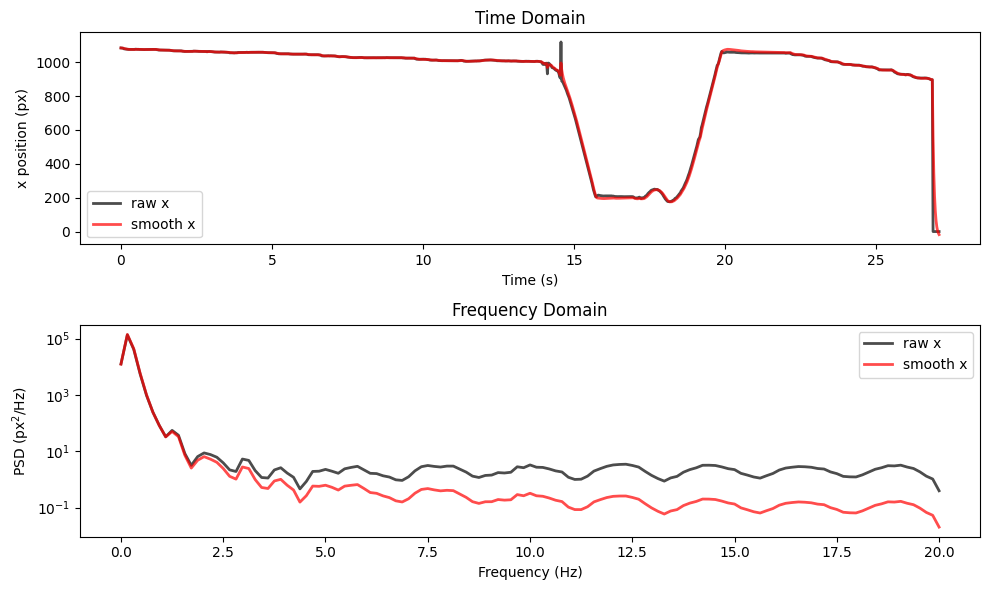

In [56]:
plot_raw_and_smooth_timeseries_and_psd(
    ds_wasp, filtered_ds, keypoint="stinger"
)